# Kuramoto Network Frequency Synchronization

In [1]:
import numpy as np
import time
from scipy import sparse
import matplotlib.pyplot as plt

#### Creates NxN interaction matrix with local uniform coupling k. Aperiodic by default (set periodic = True to make periodic).
#### Radius determines range of local interactions. By default radius = 1 (i.e., each oscilliator interacts only with its 2 closest neighbors)

In [2]:
def interaction_matrix(N,periodic = False, radius = 1):
   
    W = np.zeros((N,N))
    for i in range(-radius,radius+1):
        #vec = (i!=0)*(k/(2**(abs(i)-1)))*np.ones(N-abs(i))
        vec = (i!=0)*(1)*np.ones(N-abs(i))
        W += np.diag(vec,i)

        if periodic:
            if i != 0:
               for j in range(abs(i)):
#                W[j,N-abs(i)+j] = k/(2**(abs(i)-1))
#                W[N-1-j,abs(i)-1-j] = k/(2**(abs(i)-1))
                W[j,N-abs(i)+j] = 1
                W[N-1-j,abs(i)-1-j] = 1
        else:
            W[0:radius,:] = np.zeros((radius,N))
            W[-radius:,:] = np.zeros((radius,N))
                
    return W

In [3]:
def dist(N,i,j):
   
    return min(abs(i-j),N-abs(i-j))

def time_delay_matrix(N,alpha):
    N = int(N)
    A = np.zeros((N,N))
    
    for i in range(N):
        for j in range(N):
            A[i,j] = alpha*2*np.pi*dist(N,i,j)/(2*N)
            #A[i,j] = alpha*np.pi/2
    
    return A

#### Defines oscillator object with attributes phase ([0,2pi]) and frequency

In [4]:
class oscillator:
    def __init__(self,phase,frequency):
        self.phase = phase
        self.frequency = frequency

#### Creates population of oscillators with uniform random phases and frequencies drawn from a narrow normal distribution. 

#### By default, uniform mean frequency (gradient= None). 

#### Set gradient = "linear","quadratic", or "exp" to introduce corresponding frequency gradient starting at freq_0 and ending at freq_final  

In [5]:
def create_population(N,freq_0,freq_std, gradient = None, delta_freq = 1):
    population = []

    for i in range(N):
        phase_i = 2*np.pi*np.random.rand()
        #uniformily spread out phases:
        #phase_i = 2*np.pi*i/N
        if gradient != None:
            if gradient == "linear":
                freq_i = freq_0+(i/(N-1))*delta_freq + np.random.normal(0,freq_std)
            if gradient == "quadratic":
                freq_i = freq_0 + (i/(N-1))**2*delta_freq+np.random.normal(0,freq_std)
            if gradient == "cubic":
                freq_i = freq_0 + (i/(N-1))**3*delta_freq+np.random.normal(0,freq_std)
            if gradient == "sqrt":
                freq_i = freq_0 + (i/(N-1))**0.5*delta_freq+np.random.normal(0,freq_std)
            if gradient == "exponential":
                freq_i = freq_0 + (np.exp(i)-1)/(np.exp(N-1)-1)*delta_freq +np.random.normal(0,freq_std)
            if gradient == "sine":
                freq_i = freq_0 + 6*np.sin(np.pi*i/N)        
        else:
            freq_i = np.random.normal(freq_0,freq_std)
        population.append(oscillator(phase_i,freq_i))

    return population

#### Introduces a total of num_defects defects into population.

#### Each defect is implemented as an oscillator that is cut off from interacting with the rest

In [6]:
def introduce_defects(W,num_defects,loc_variability = False):
    
    N = np.shape(W)[0]
    indices = np.linspace(0,N-1,num_defects)
    
    for i in indices:
        
        if loc_variability:
            x = int(np.random.normal(float(i),2))
        else:
            x = int(i)
        
        W[:,x] = np.zeros(N)
        W[x,:] = np.zeros(N)
    
    return W

### Single time step update to oscillator population using a fourth order Runge-Kutta method (RK4)

In [7]:
## f = dTheta/dt 
def f(W,k,frequencies,thetas):
    f = frequencies+k*np.imag(np.exp(-1j*thetas)*W.dot(np.exp(1j*thetas)))
    return f


def update_population_RK(W,k_temp,a,total_phases,thetas,frequencies,dt):
    
    k1 = dt*f(W,k,frequencies,thetas)
    
    k2 = dt*f(W,k,frequencies,thetas+0.5*k1)
    
    k3 = dt*f(W,k,frequencies,thetas+0.5*k2)
    
    k4 = dt*f(W,k,frequencies,thetas+k3)
    
    delta_theta = (k1+2*k2+2*k3+k4)/6
    
    thetas += delta_theta
    thetas = np.mod(thetas,2*np.pi)
    total_phases += delta_theta
    
    return (thetas, total_phases)

### Models evolution of population for time T

In [8]:
def update_system(W,k_t,vel_t,total_phases,thetas,frequencies,T,dt,N):
    
    ## keeps track of population pattern (phases) in time 
    system_t  = np.zeros((int(T/dt),N))
    
    system_t_total = np.zeros((int(T/dt),N))
    
    for t in range(int(T/dt)):
        
        system_t[t,:] = thetas.flatten()
        system_t_total[t,:] = total_phases.flatten()
        
        if vel_t is None:
            a = None
        else:
            if t < 0.4*int(T/dt):
                a = 1
            else:
                a = vel_t[t]
        
        try:
            k_temp = k_t[t]
        except:
            k_temp = k_t
        
        thetas, total_phases = update_population_RK(W,k_temp,a,total_phases,thetas,frequencies,dt)
            
    
    return (system_t, system_t_total)

### Creates "random walk" time series of velocities

In [9]:
def create_vel(T,dt):
    
    def f(y,t):
        return 0.0
    
    def G(y,t):
        if t < int(0.0*T):
            return 0
        else:
            return 0.001
    
    y0 = 0
    
    tspan = np.linspace(0,T,int(T/dt))
    
    return sdeint.itoint(f=f,G=G,y0 = y0,tspan = tspan)

## Runs Simulation

In [10]:
def simulate(N,k,k_dynamic,velocity,alpha,radius,periodic,defects,num_defects,freq_0,delta_freq,freq_std,gradient,T,dt):
    
    start_time = time.time()
    

    ## population of N oscillators 
    population = create_population(N,freq_0,freq_std,gradient = gradient,delta_freq = delta_freq)
    
    ## Nx1 vectors containing the phase and frequency of each oscillator 
    phases = np.array([[oscillator.phase for oscillator in population]]).T
    total_phases = np.array([[oscillator.phase for oscillator in population]]).T
    frequencies = np.array([[oscillator.frequency for oscillator in population]]).T
    
    
#    if periodic == False:
#        N = N + 2*radius
#        left_phases = 2*np.pi*np.random.random_sample((radius,1))
#        right_phases = 2*np.pi*np.random.random_sample((radius,1))
#        phases = np.concatenate((left_phases,phases,right_phases))
#        total_phases = np.ndarray.copy(phases)
#        left_freqs = freq_0*np.ones((radius,1)) +  np.random.normal(0,freq_std,(radius,1))
#        right_freqs = (freq_0+delta_freq)*np.ones((radius,1)) + np.random.normal(0,freq_std,(radius,1))    
#        frequencies = np.concatenate((left_freqs,frequencies,right_freqs))
#        
        
    ## Matrix of pair-wise oscillator couplings 
    W = interaction_matrix(N,periodic = periodic,radius = radius)

    
    if defects:
        W = introduce_defects(W,num_defects)

    
    A = time_delay_matrix(N,alpha)
    W = W*np.exp(-1j*A)

    

        
        
    ## Interaction matrix in sparse format
    W = sparse.csr_matrix(W)
    
    ## if k_dynamic == True, models k as a saturating exponential
    if k_dynamic:
        t = np.linspace(0,T,int(T/dt))
        k_t = k*(1-np.exp(-t/(0.2*T)))
    else:
        k_t = k
        
    ## time series of input velocities 
    if velocity:
        vel_t = 10*create_vel(T,dt) + 1
        np.save("trajectory.npy",vel_t)
        import matplotlib.pyplot as plt
        plt.plot(vel_t)
    else:
        vel_t = None
    

    ##updates all oscillators 
    system_t, system_t_total = update_system(W,k_t,vel_t,total_phases,phases,frequencies,T,dt,N)
    
    simulation_time = time.time() - start_time
    
    print(simulation_time)
    
    return system_t, system_t_total, frequencies, sparse.csr_matrix.todense(W)


# Analysis/Plotting Functions

In [11]:
## Calculates numerical time derivative of oscillator phases at all times t 
def calc_eff_freq(system_t,dt):
    size = np.shape(system_t)
    eff_freqs_t = np.zeros((size[0]-2,size[1]))
    for t in range(1,size[0]-1):  
        delta = (system_t[t+1]-system_t[t-1])
        eff_freqs_t[t-1,:] = delta/(2*dt)
    return eff_freqs_t



## Calculates order parameter r (population phase-coherence)
def local_order_parameter(phase_data,W,R):
    dims = np.shape(phase_data)
  
    r = np.zeros(dims)
  
    for t in range(dims[0]):
        r_t = np.abs(np.dot(W,np.exp(1j*phase_data[t][:])))
        r[t,:] = r_t
        
        
    return r/(2*R)


def eff_freqs_std(eff_freqs):
    return np.std(eff_freqs) 


def errorfill(x, y,yerr, color=None, alpha_fill=0.3, ax=None):
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    a = plt.figure(dpi=100)
    plt.plot(x, y, color=color,figure=a)
    plt.fill_between(x, ymax, ymin, color="red", alpha=alpha_fill)
    plt.xlabel("Oscillator")
    #plt.ylabel("⟨dθ/dt⟩/⟨α(t)⟩")
    plt.ylabel("⟨dθ/dt⟩")
    #plt.savefig('k=' + str(k) +'.png')

# Simulation

11.914980173110962


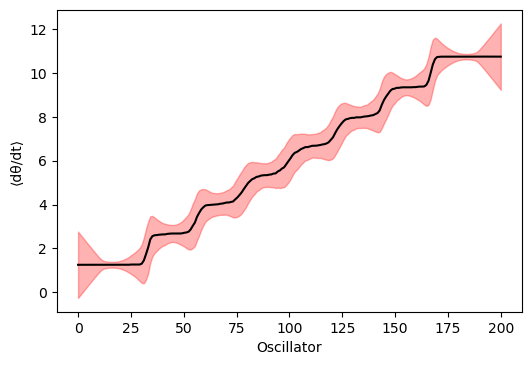

In [12]:
# N : number of oscillators
N = 200
# k : coupling constant
k = 0.19 #0.17 #0.18
# k_dynamic: set to True to make k a dynamic variable
k_dynamic = False
# velocity: set to True to introduce velocity inputs, False otherwise
velocity = False
# alpha: time delay constant
alpha = 0.0
# radius : radius of local interactions
radius = 12 #int(0.1*N)
# periodic : set to True for periodic topology, set to False for aperiodic topology
periodic = True
# defects : set to True to introduce sparse uniformly ditributed defects 
defects = False
# num_defects : specify number of defects to introduce 
num_defects = int(0.05*N)
# freq_0 : initial center of frequency distribution
freq_0 = 0
# delta_freq : absolute change in frequency due to gradient. final freq = freq_0 + delta_freq
delta_freq = 0.06*N
# freq_std : std of frequency distribution
freq_std = 0.0
# gradient : sets functional form of population frequency gradient. gradient one of {None,"linear","quadratic","exponential"}
gradient = "linear" 
# T : simulation time length
T = 800
# dt : time step width
dt = 0.01


phases, phases_total, freqs, W = simulate(N,k,k_dynamic,velocity,alpha,radius,periodic,defects,num_defects,freq_0,delta_freq,freq_std,gradient,T,dt)

# if not periodic:
#     N = N + 2*radius

eff_freqs = calc_eff_freq(phases_total,dt)

x = np.linspace(0,N,N)
y = np.mean(eff_freqs[int(0.9*N):],axis=0)
yerr = np.std(eff_freqs[int(0.9*N):],axis=0)

errorfill(x,y,yerr,color="black")

# Count number of modules:

1. Find numerical derivative
2. Smooth out resulting derivative. Use either Gaussian filter or Savitzky-Golay filter (play around with filter params, but Gaussian should be mostly fine)
3. Find peaks using scipy.signal 
4. Check to see if modules are evenly spread out. If not, may indicate lack of consistent module formation

8 modules detected


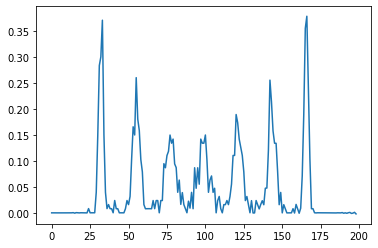

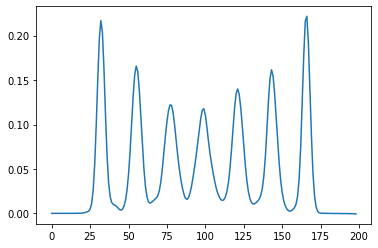

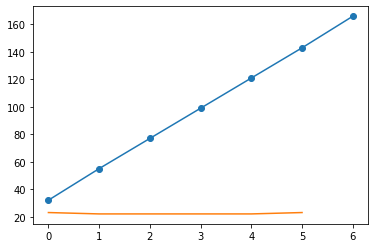

In [17]:
## 1
x = np.linspace(0,N,N)
y = np.mean(eff_freqs[int(0.9*N):],axis=0)
deriv = np.diff(y)
plot1 = plt.figure()
plt.plot(deriv)

## 2 
from scipy import ndimage
from scipy import signal
smooth_deriv = ndimage.gaussian_filter1d(deriv,sigma=2)
#smooth_deriv = signal.savgol_filter(deriv,7,2)
plot2 = plt.figure()
plt.plot(smooth_deriv)

## 3
peaks = signal.find_peaks(smooth_deriv,prominence = 0.05)#,width=radius/2)
num_steps = len(peaks[0]) + 1 
print(str(num_steps) + " modules detected")

## 4 
plot3 = plt.figure()
plt.plot(peaks[0],marker="o")
plt.plot(np.diff(peaks[0]))

module_holes = signal.find_peaks(np.diff(peaks[0]),threshold=radius)
if len(module_holes[0]) > 0:
    print("No Modules: " + str(len(module_holes[0])) + " inconsistencies found")

# Create Phase Diagram from imported data

In [19]:
ps = np.load("phase_space.npy")
np.shape(ps)

(546, 3)

(96, 200)

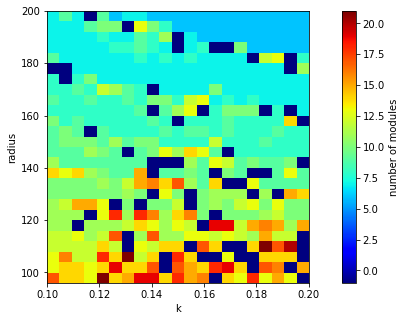

In [24]:
## Double loop through different values of radius & k to fill matrix:

num_values_of_radius = 26
num_values_of_k = 21

starting_radius = 96
starting_k = 0.1

step_size_radius = 4
step_size_k = 5

M = np.zeros((num_values_of_radius,num_values_of_k))

for m in ps:
    i = int((m[1] - starting_radius)/step_size_radius)
    j = int(round((m[0]-starting_k)*1000/step_size_k))
    M[i,j] = m[2]



fig, ax1 = plt.subplots(figsize=(12,5))


pos = ax1.imshow(M, cmap = 'jet', interpolation='none', extent=[0.1,0.2,200,96])
fig.colorbar(pos,ax=ax1,label="number of modules")
ax1.set_aspect(0.001)
plt.xlabel("k")
plt.ylabel("radius")
plt.ylim(96,200)


# plt.colorbar()
# fig, ax = plt.subplots(figsize=(6,6))